In [1]:
from google.colab import files
uploaded = files.upload()

Saving SGMD.xlsx to SGMD.xlsx


In [2]:
import pandas as pd


In [3]:
df_5 = pd.read_excel("SGMD.xlsx")

In [4]:
df_4 = df_5.iloc[: , 2 : ]

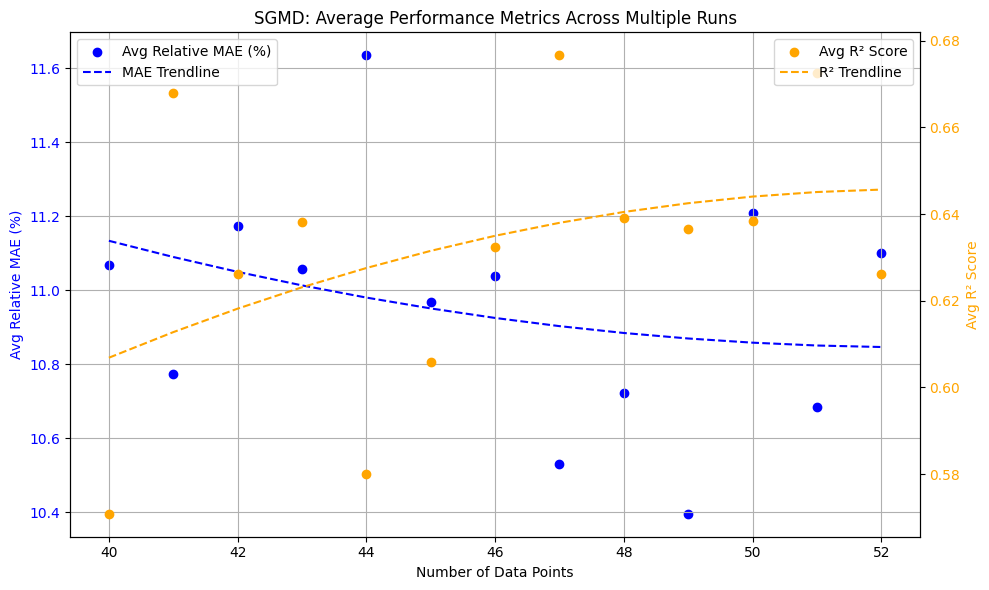

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Parameters
seeds = [101, 102, 103, 104, 105]  # List of seeds for multiple runs
n_data_points_range = range(40, 53)  # Range of subset sizes
n_folds = 5  # Number of folds for cross-validation

# Prepare dictionaries to store results for each subset size
relative_mae_dict = {n: [] for n in n_data_points_range}
r2_dict = {n: [] for n in n_data_points_range}

# Loop through each seed
for seed in seeds:
    for n_data_points in n_data_points_range:
        # Randomly sample n_data_points from df_4 with the current seed
        df_sample = df_4.sample(n=n_data_points, random_state=seed)

        # Split data into features (X) and target (y)
        X = df_sample.iloc[:, :-1].to_numpy()  # All columns except the last one
        y = df_sample.iloc[:, -1].to_numpy()   # Last column is the target value

        # Normalize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # K-fold cross-validation
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
        fold_mae_list = []
        fold_r2_list = []

        for train_index, test_index in kf.split(X_scaled):
            # Split data
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Define and tune XGBoost model
            xgb_model = XGBRegressor(objective='reg:squarederror', random_state=seed)
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.3],
                'colsample_bytree': [0.7, 0.8, 0.9],
            }
            grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)

            # Get best model and make predictions
            best_model = grid_search.best_estimator_
            y_test_pred = best_model.predict(X_test)

            # Calculate metrics
            mae_test = mean_absolute_error(y_test, y_test_pred)
            relative_mae = (mae_test / np.mean(y_test)) * 100  # Convert to percentage
            fold_mae_list.append(relative_mae)

            r2_test = r2_score(y_test, y_test_pred)
            fold_r2_list.append(r2_test)

        # Store the average metrics for this subset size
        relative_mae_dict[n_data_points].append(np.mean(fold_mae_list))
        r2_dict[n_data_points].append(np.mean(fold_r2_list))

# Calculate the averages across all seeds for each subset size
average_relative_mae = {n: np.mean(relative_mae_dict[n]) for n in n_data_points_range}
average_r2 = {n: np.mean(r2_dict[n]) for n in n_data_points_range}

# Convert to arrays for plotting
subset_sizes = np.array(list(average_relative_mae.keys()))
avg_relative_mae_values = np.array(list(average_relative_mae.values()))
avg_r2_values = np.array(list(average_r2.values()))

# Fit polynomial trendlines
poly_features = PolynomialFeatures(degree=2)
X_poly_mae = poly_features.fit_transform(subset_sizes.reshape(-1, 1))
mae_model = LinearRegression()
mae_model.fit(X_poly_mae, avg_relative_mae_values)
mae_trend = mae_model.predict(X_poly_mae)

X_poly_r2 = poly_features.fit_transform(subset_sizes.reshape(-1, 1))
r2_model = LinearRegression()
r2_model.fit(X_poly_r2, avg_r2_values)
r2_trend = r2_model.predict(X_poly_r2)

# Plot results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Relative MAE
ax1.scatter(subset_sizes, avg_relative_mae_values, color='blue', label='Avg Relative MAE (%)')
ax1.plot(subset_sizes, mae_trend, color='blue', linestyle='--', label='MAE Trendline')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Avg Relative MAE (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a second y-axis for R²
ax2 = ax1.twinx()
ax2.scatter(subset_sizes, avg_r2_values, color='orange', label='Avg R² Score')
ax2.plot(subset_sizes, r2_trend, color='orange', linestyle='--', label='R² Trendline')
ax2.set_ylabel('Avg R² Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legends
plt.title('SGMD: Average Performance Metrics Across Multiple Runs')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()
